## Deep Learning in Winonsin Breast Cancer Diagnosis

#### Import necessary libraries

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [2]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [3]:
data = data.fillna(0)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Value ranges of data columns

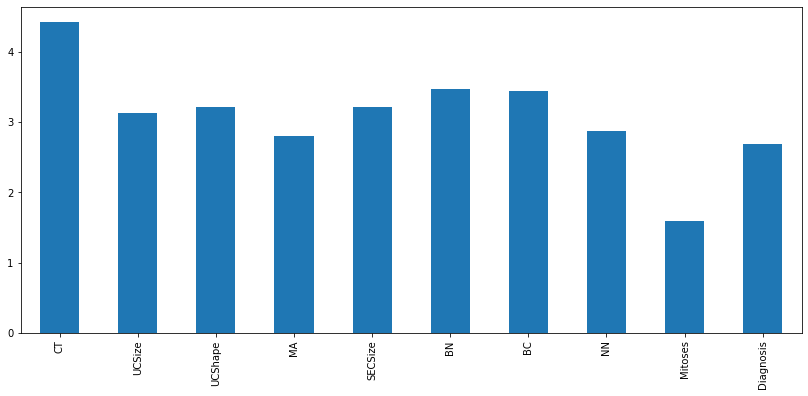

In [4]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
data_mean = data.describe().loc['mean']
data_mean.plot(kind='bar', figsize=(14,6))

#### Samples from dataset labled as B

In [5]:
data_B = data[data['Diagnosis'] == 2]
data_B.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,2.956332,1.325328,1.443231,1.364629,2.120087,1.305677,2.100437,1.290393,1.063319,2.0
std,1.674318,0.907694,0.997836,0.996830,0.917130,1.182666,1.080339,1.058856,0.501995,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.0
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.0
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.0
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,9.000000,8.000000,2.0


#### Samples from dataset labeled as M

In [6]:
data_M = data[data['Diagnosis'] == 4]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,7.195021,6.572614,6.560166,5.547718,5.298755,7.564315,5.979253,5.863071,2.589212,4.0
std,2.428849,2.719512,2.562045,3.210465,2.451606,3.180182,2.273852,3.350672,2.557939,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000,4.0
75%,10.000000,10.000000,9.000000,8.000000,6.000000,10.000000,7.000000,10.000000,3.000000,4.0
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.0


#### Bar chart of the total numbers of B and M

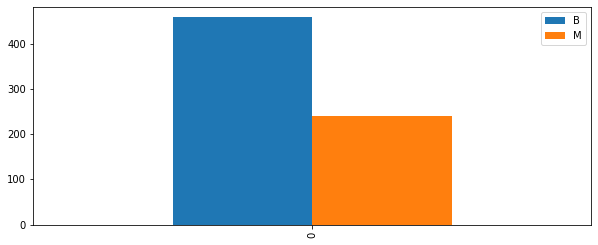

In [7]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))

#### Define a data generation function with random noise

In [8]:
def generateData(data1):
    # make a copy of data
    data2 = data1.copy()

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Expand the set of data samples labeled as M

In [9]:
data_M_copy = data_M.copy();

new_data_M = generateData(data_M_copy)
data_M = data_M.append(new_data_M, ignore_index=True)

data_M = data_M[data_M['Diagnosis'] >= 4.0]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.0
mean,7.194409,6.570930,6.561236,5.548503,5.299247,7.566676,5.981332,5.863282,2.589742,4.0
std,2.427268,2.717135,2.563860,3.208950,2.452099,3.176346,2.268344,3.351296,2.556342,0.0
min,1.000000,0.834022,0.874441,0.790033,0.869303,0.000000,1.000000,0.803263,0.812769,4.0
25%,5.000000,4.000000,4.000605,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,7.963981,6.000000,6.136080,5.000000,5.000000,9.981701,6.955362,6.000000,1.000000,4.0
75%,10.000000,9.962605,9.000000,8.000000,6.190424,10.000000,7.106344,9.863347,3.000000,4.0
max,10.290546,10.255989,10.114403,10.201289,10.306348,10.220957,10.000000,10.246311,10.133132,4.0


#### Bar chart of the total numbers of B and M after expanding the set of samples labeled as M

,B,M
0,458,482


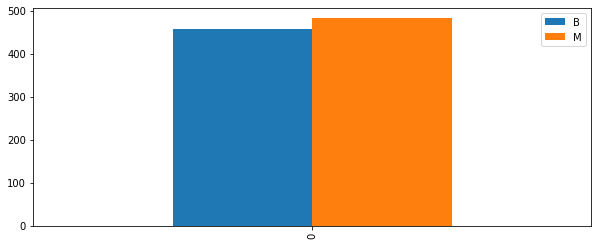

In [10]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))
B_M_df.head()

#### Combine the new set of M samples with the original set of B samples into one new dataset

In [11]:

data = data_B.append(data_M, ignore_index=True)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,5.129473,4.015094,4.067570,3.509977,3.750252,4.516104,4.090427,3.635215,1.846017,3.025532
std,2.979009,3.326370,3.225363,3.183772,2.452999,3.956381,2.640195,3.395407,2.013170,1.000206
min,1.000000,0.834022,0.874441,0.790033,0.869303,0.000000,1.000000,0.803263,0.812769,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,4.000000
75%,8.000000,7.000000,7.000000,5.089772,5.000000,10.000000,7.000000,6.000000,1.093506,4.000000
max,10.290546,10.255989,10.114403,10.201289,10.306348,10.220957,10.000000,10.246311,10.133132,4.000000


#### Expand the new combined dataset

In [12]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

data = data.fillna(0)

print("data size = ", data.shape[0])

data size =  1880


#### Scale dataset to the range of [0, 1]

In [13]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [14]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

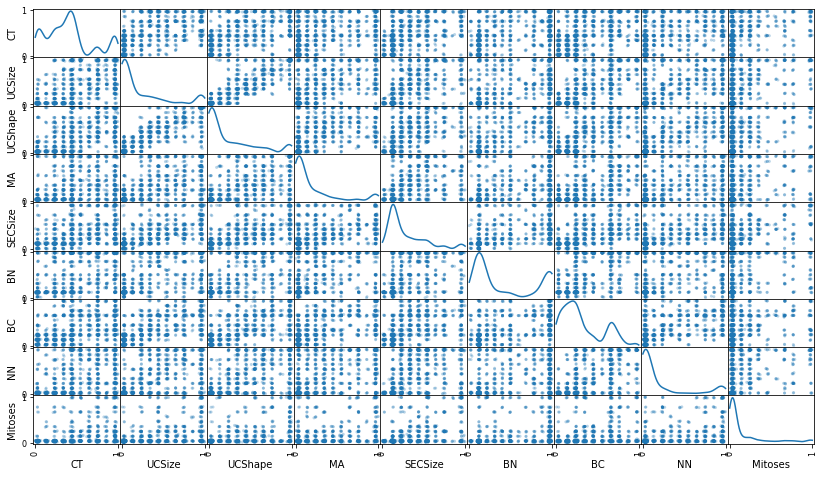

In [15]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

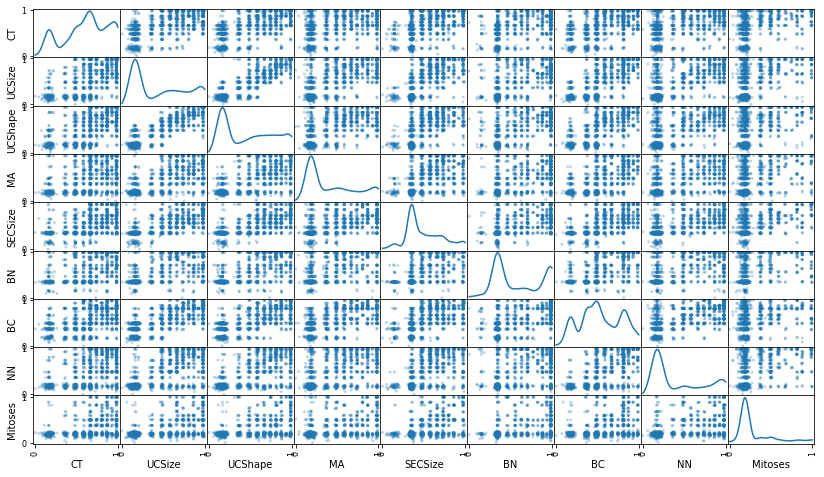

In [16]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [17]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [18]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [19]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

score =  0.9723404255319149


/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Deep learning

In [21]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

Using TensorFlow backend.


#### K-fold cross validation

In [22]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X = X_train
Y = y_train

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    # create model
    model = Sequential()
    model.add(Dense(9, activation='relu', input_dim=9))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='relu', input_shape=(9,)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', input_shape=(5,)))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    model.fit(X[train], Y[train], epochs=500, batch_size=10, verbose=0)
    
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
accuracy: 98.59%
accuracy: 97.89%
accuracy: 98.59%
accuracy: 99.29%
accuracy: 95.74%
accuracy: 97.16%
accuracy: 98.58%
accuracy: 97.14%
accuracy: 98.57%
accuracy: 95.00%
97.66% (+/- 1.32%)


#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [23]:
#Define your architecture.
model = Sequential()
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_21 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 50        
_________________________________________________________________
dropout_22 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model
* Note that the "accuracy" metrics supports the history of "acc", but the "binary_accuracy" accuracy does not!

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc']) # ['binary_accuracy']

#### Train NN Model

In [25]:
# model.fit(X_train, y_train, epochs=800, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=1)

Epoch 1/1000
1410/1410 [==============================] - 0s 165us/step - loss: 0.7033 - acc: 0.4851
Epoch 2/1000
1410/1410 [==============================] - 0s 49us/step - loss: 0.6796 - acc: 0.5057
Epoch 3/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.6776 - acc: 0.5348
Epoch 4/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.6565 - acc: 0.5723
Epoch 5/1000
1410/1410 [==============================] - 0s 51us/step - loss: 0.6462 - acc: 0.5773
Epoch 6/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.6203 - acc: 0.6184
Epoch 7/1000
1410/1410 [==============================] - 0s 49us/step - loss: 0.6076 - acc: 0.6454
Epoch 8/1000
1410/1410 [==============================] - 0s 50us/step - loss: 0.5745 - acc: 0.6681
Epoch 9/1000
1410/1410 [==============================] - 0s 49us/step - loss: 0.5675 - acc: 0.6872
Epoch 10/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.5409 - acc: 0.704

Epoch 162/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3162 - acc: 0.8532
Epoch 163/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3220 - acc: 0.8454
Epoch 164/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3211 - acc: 0.8482
Epoch 165/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3159 - acc: 0.8567
Epoch 166/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3118 - acc: 0.8461
Epoch 167/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3334 - acc: 0.8461
Epoch 168/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3216 - acc: 0.8397
Epoch 169/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3259 - acc: 0.8418
Epoch 170/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3282 - acc: 0.8440
Epoch 171/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0

1410/1410 [==============================] - 0s 51us/step - loss: 0.3040 - acc: 0.8454
Epoch 323/1000
1410/1410 [==============================] - 0s 49us/step - loss: 0.3007 - acc: 0.8553
Epoch 324/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3174 - acc: 0.8489
Epoch 325/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3244 - acc: 0.8305
Epoch 326/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.2984 - acc: 0.8603
Epoch 327/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3355 - acc: 0.8418
Epoch 328/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3288 - acc: 0.8475
Epoch 329/1000
1410/1410 [==============================] - 0s 46us/step - loss: 0.3172 - acc: 0.8475
Epoch 330/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3293 - acc: 0.8567
Epoch 331/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.2959 - acc: 0.

1410/1410 [==============================] - 0s 48us/step - loss: 0.3242 - acc: 0.8305
Epoch 483/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3373 - acc: 0.8461
Epoch 484/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.2989 - acc: 0.8589
Epoch 485/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3349 - acc: 0.8433
Epoch 486/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3097 - acc: 0.8546
Epoch 487/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.2933 - acc: 0.8667
Epoch 488/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3129 - acc: 0.8489
Epoch 489/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.2956 - acc: 0.8596
Epoch 490/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3014 - acc: 0.8546
Epoch 491/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3012 - acc: 0.

1410/1410 [==============================] - 0s 48us/step - loss: 0.3307 - acc: 0.8326
Epoch 643/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.2964 - acc: 0.8596
Epoch 644/1000
1410/1410 [==============================] - 0s 49us/step - loss: 0.3220 - acc: 0.8397
Epoch 645/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3248 - acc: 0.8447
Epoch 646/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3252 - acc: 0.8560
Epoch 647/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3331 - acc: 0.8440
Epoch 648/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3243 - acc: 0.8475
Epoch 649/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3092 - acc: 0.8475
Epoch 650/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3096 - acc: 0.8553
Epoch 651/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3092 - acc: 0.

1410/1410 [==============================] - 0s 48us/step - loss: 0.3079 - acc: 0.8582
Epoch 803/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3216 - acc: 0.8532
Epoch 804/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3157 - acc: 0.8482
Epoch 805/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.2996 - acc: 0.8539
Epoch 806/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3460 - acc: 0.8426
Epoch 807/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3277 - acc: 0.8362
Epoch 808/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3256 - acc: 0.8426
Epoch 809/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3230 - acc: 0.8489
Epoch 810/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3123 - acc: 0.8596
Epoch 811/1000
1410/1410 [==============================] - 0s 54us/step - loss: 0.3201 - acc: 0.

1410/1410 [==============================] - 0s 47us/step - loss: 0.3058 - acc: 0.8496
Epoch 963/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3228 - acc: 0.8468
Epoch 964/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3321 - acc: 0.8340
Epoch 965/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3417 - acc: 0.8390
Epoch 966/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3236 - acc: 0.8511
Epoch 967/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3191 - acc: 0.8567
Epoch 968/1000
1410/1410 [==============================] - 0s 49us/step - loss: 0.3368 - acc: 0.8348
Epoch 969/1000
1410/1410 [==============================] - 0s 48us/step - loss: 0.3154 - acc: 0.8546
Epoch 970/1000
1410/1410 [==============================] - 0s 47us/step - loss: 0.3399 - acc: 0.8376
Epoch 971/1000
1410/1410 [==============================] - 0s 50us/step - loss: 0.3118 - acc: 0.

<class 'list'>


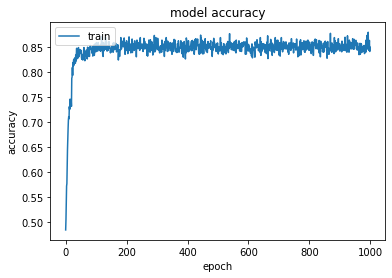

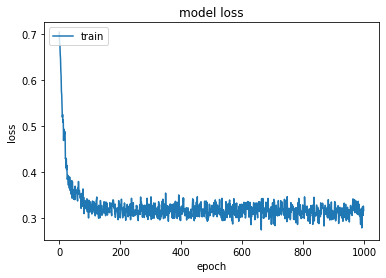

In [26]:
print(type(history.history['acc']))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Test NN Model

In [27]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

470/470 [==============================] - 0s 91us/step
score =  [0.0840891586973312, 0.9765957593917847]


#### Draw ROC Curve

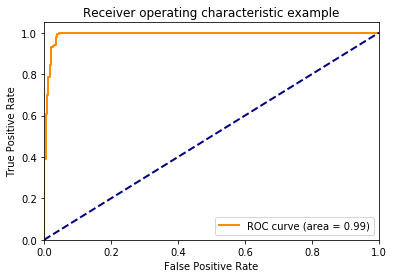

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()